In [2]:
# https://www.biaodianfu.com/python-time-series-forecasting-methods.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
print(df.head())
print(df.dtypes)
print(df.describe())

   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2
ID           int64
Datetime    object
Count        int64
dtype: object
                 ID         Count
count  18288.000000  18288.000000
mean    9143.500000    138.958115
std     5279.435197    153.467461
min        0.000000      2.000000
25%     4571.750000     22.000000
50%     9143.500000     84.000000
75%    13715.250000    210.000000
max    18287.000000   1244.000000


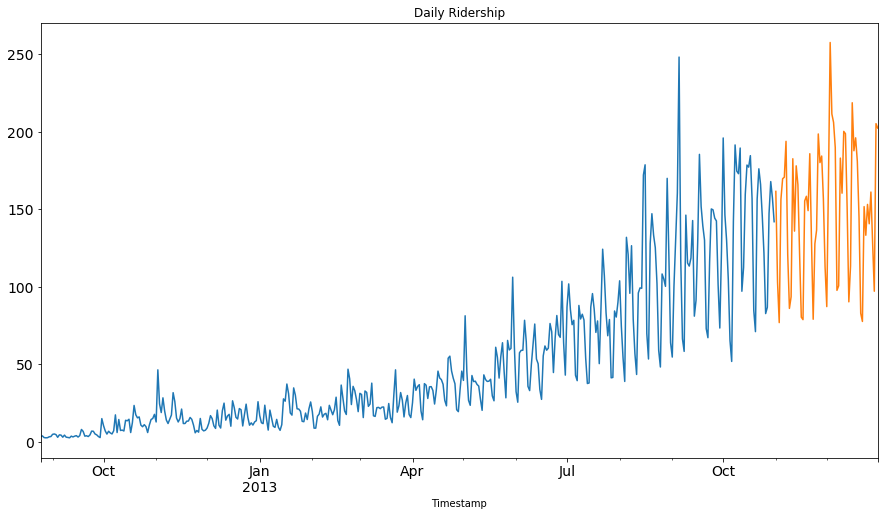

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
 
# Subsetting the dataset
# Index 11856 marks the end of year 2013
df = pd.read_csv('train.csv', nrows=11856)
 
# Creating train and test set
# Index 10392 marks the end of October 2013
train = df[0:10392]
test = df[10392:]
 
# Aggregating the dataset at daily level
df['Timestamp'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.index = df['Timestamp']
df = df.resample('D').mean()

train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
train.index = train['Timestamp']
train = train.resample('D').mean()
 
test['Timestamp'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
test.index = test['Timestamp']
test = test.resample('D').mean()
 
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

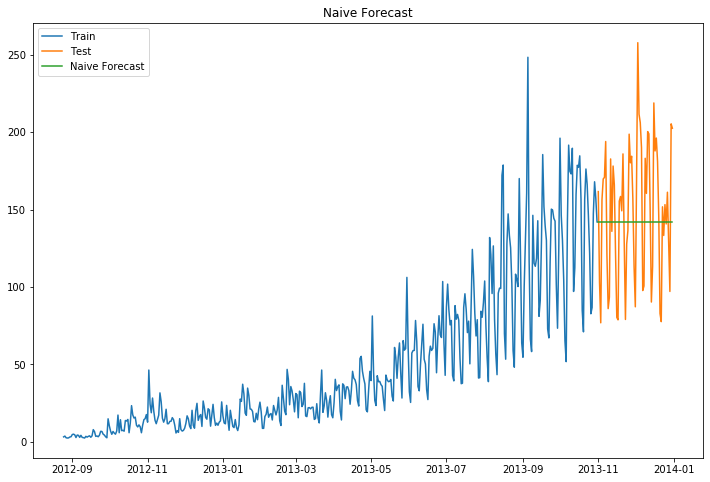

Test RMSE: 43.916


In [3]:
# 方法1：朴素法 Naive Approach

# model
dd = np.asarray(train['Count'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

# plot
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat['naive']))
print('Test RMSE: %.3f' % rms)

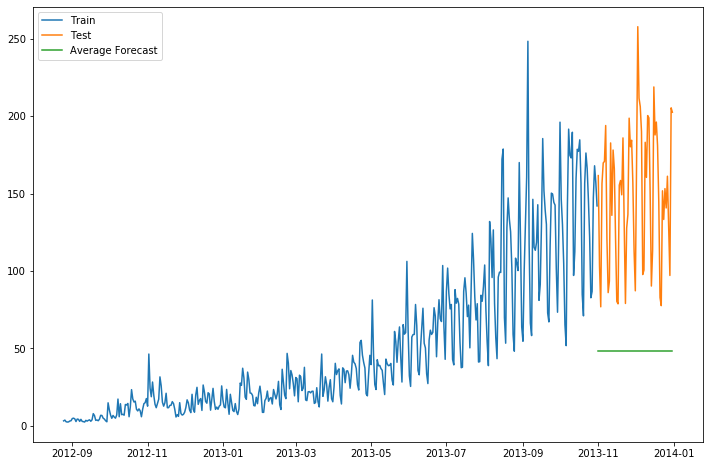

Test RMSE: 109.885


In [4]:
# 方法2：简单平均法 Simple Average

#model
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()

# plot
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['avg_forecast']))
print('Test RMSE: %.3f' % rms)

Test RMSE: 46.728


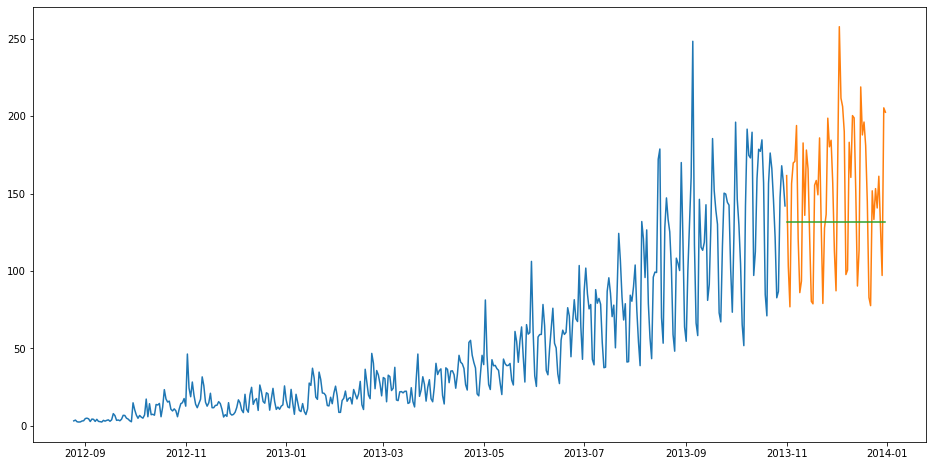

In [5]:
# 方法3：移动平均法 Moving Average

# model
y_hat_avg = test.copy()
# y_hat_avg['moving_avg_forecast'] = df['Count'].rolling(60).mean()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]


# plot
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['moving_avg_forecast']))
print('Test RMSE: %.3f' % rms)


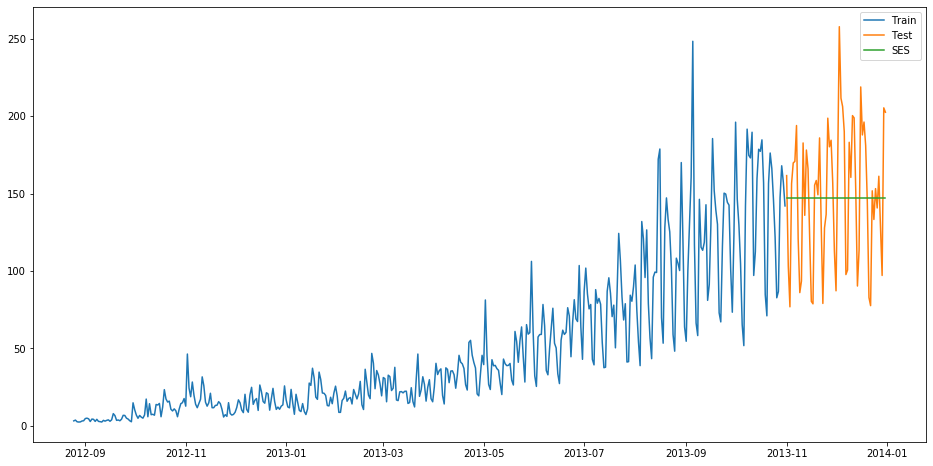

Test RMSE: 43.358


In [6]:
# 方法4：简单指数平滑法 Simple Exponential Smoothing

# model
from statsmodels.tsa.api import SimpleExpSmoothing
model = SimpleExpSmoothing(np.asarray(train['Count']))
model_fit = model.fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = model_fit.forecast(len(test))

# plot
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['SES']))
print('Test RMSE: %.3f' % rms)

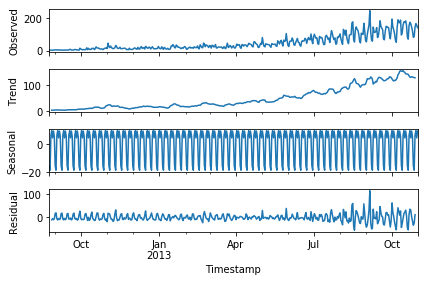

In [19]:
# 方法5：霍尔特(Holt)线性趋势法 Holt’s Linear Trend method

import statsmodels.api as sm

sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

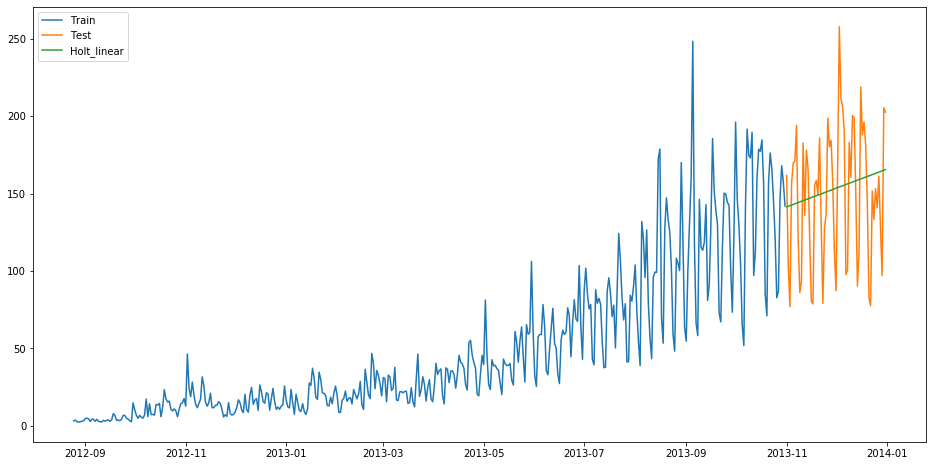

Test RMSE: 43.056


In [33]:
from statsmodels.tsa.api import Holt

# model
y_hat_avg = test.copy()

fit = Holt(np.asarray(train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(test))

# plot
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_linear']))
print('Test RMSE: %.3f' % rms)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


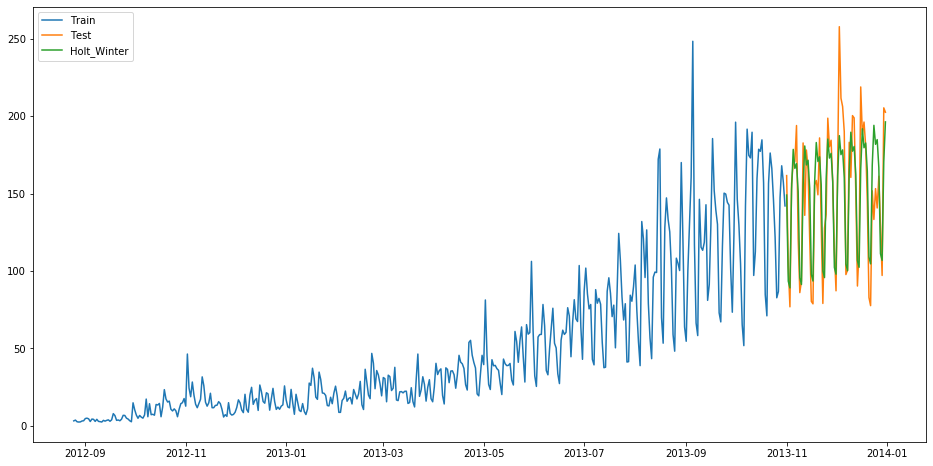

23.961492566159794


In [43]:
# 方法6：Holt-Winters季节性预测模型 Holt-Winters Method
from statsmodels.tsa.api import ExponentialSmoothing

# model
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']),seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

# plot
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_Winter']))
print(rms)

In [7]:
# 方法7：自回归移动平均模型（ARIMA） AutoreRressive Integrated Moving Average
import statsmodels.api as sm

# model 
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2016-12-31", dynamic=True)


# plot
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['SARIMA']))
print('Test RMSE: %.3f' % rms)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2013-11-01    140.673324
2013-11-02     94.088328
2013-11-03     94.914113
2013-11-04    154.036485
2013-11-05    180.884097
2013-11-06    171.747704
2013-11-07    166.207151
2013-11-08    153.297741
2013-11-09    100.503678
2013-11-10     95.056598
2013-11-11    159.229058
2013-11-12    185.479468
2013-11-13    173.166880
2013-11-14    171.425217
2013-11-15    156.904091
2013-11-16    102.946418
2013-11-17     99.940815
2013-11-18    162.416021
2013-11-19    188.615984
2013-11-20    177.635673
2013-11-21    174.527340
2013-11-22    160.443132
2013-11-23    107.054746
2013-11-24    103.119644
2013-11-25    166.145841
2013-11-26    192.465356
2013-11-27    180.943756
2013-11-28    178.316035
2013-11-29    164.133019
2013-11-30    110.486611
                 ...    
2016-12-02    733.158060
2016-12-03    679.590000
2016-12-04    675.908348
2016-12-05    738.802727
2016-12-06    765.070220
2016-12-07    753.702811
2016-12-08    750.951723
2016-12-09    736.782578
2016-12-10    683.214517
